# How do socioeconomic factors affect crime rates in Seattle?
## Chantria Im, Ellie Velez, and Nawaf Osman

In [1]:
%%capture
%%script echo skipping # Skip this code cell

# Install packages
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install requests
!{sys.executable} -m pip install numpy matplotlib

In [2]:
# Import libraries
import pandas as pd
import requests
import re
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
# Load datasets
crime_df = pd.read_csv('./data/SPD_Crime_Data__2008-Present_20240226.csv')
poverty_df = pd.read_csv('./data/Poverty_and_Near_Poverty_Map_Full_Data_data.csv', 
                         converters={'Census Tract': str.strip})
income_df = pd.read_csv('./data/ACSST5Y2018.S1903-Data.csv')

In [4]:
# Remove rows with missing Longitude and Latitude values
crime_df = crime_df[(crime_df['Longitude'] != 0) & (crime_df['Latitude'] != 0)]

# Filter for only 2018 entries
crime_df['Report DateTime'] = pd.to_datetime(crime_df['Report DateTime'], format='%m/%d/%Y %I:%M:%S %p')
crime_df = crime_df[crime_df['Report DateTime'].dt.year == 2018]

# Add Census Tract column
crime_df['Census Tract'] = pd.Series(dtype='string')

In [5]:
%%capture
%%script echo skipping # Skip this code cell

# Fill Census Tract column with corresponding census tract numbers
i = 0
while i < len(crime_df):
    # Make request to Census Geocoder API to get row's census tract data based on row's longtitude and latitude values
    payload = {'benchmark': 'Public_AR_Current', 'vintage': 'ACS2018_Current', 'x': crime_df['Longitude'].iloc[i], 
               'y': crime_df['Latitude'].iloc[i], 'format': 'json', 'layers': 'Census Tracts'}
    try:
        r = requests.get(f'https://geocoding.geo.census.gov/geocoder/geographies/coordinates', params=payload)
    except requests.Timeout:
        time.sleep(300)
        continue
    # Extract the census tract number from the response and store it in the Census Tract column
    crime_df['Census Tract'].iloc[i] = re.findall('\d+\.\d+|\d+', 
                                                  r.json()['result']['geographies']['Census Tracts'][0]['NAME'])[0]
    i += 1

# Backup dataframe to disk 
crime_df.to_csv('./data/crime.csv')

In [6]:
pd.set_option('display.max_colwidth', None)

# Cache the dataframe
#%store crime_df
# Reload the dataframe from cache rather than recomputing (5+ hours)
%store -r crime_df

In [7]:
# Drop empty columns
poverty_df = poverty_df.drop(['% of Population Under 100% Poverty Line', '% of Population Under 200% Poverty Line', 
                              'Share Below Selected % of Poverty Level'], axis=1)

# Group data by census tract and calculate total poverty population for levels
poverty_by_tract = poverty_df[poverty_df['Name'] != 'Total'].groupby('Census Tract').agg(
    {'Population Under 100% Poverty Level': 'sum', 'Population Under 200% Poverty Level': 'sum'})

# For each census tract fill designated 'Total' row with total poverty populations for levels
poverty_df.loc[
    poverty_df['Name'] == 'Total', 
    'Population Under 100% Poverty Level'] = poverty_df.loc[
    poverty_df['Name'] == 'Total', 'Census Tract'].map(poverty_by_tract['Population Under 100% Poverty Level']).values
poverty_df.loc[
    poverty_df['Name'] == 'Total', 
    'Population Under 200% Poverty Level'] = poverty_df.loc[
    poverty_df['Name'] == 'Total', 'Census Tract'].map(poverty_by_tract['Population Under 200% Poverty Level']).values

# Filter for only designated 'Total' rows
poverty_df = poverty_df[poverty_df['Name'] == 'Total']

In [8]:
# Remove rows with missing median income values
income_df = income_df[pd.to_numeric(income_df['S1903_C03_001E'], errors='coerce').notna()] # 53.02 University District Missing

# Extract and set census tract numbers
for i in range(len(income_df)):
    income_df.iat[i, income_df.columns.get_loc('NAME')] = re.findall('\d+\.\d+|\d+', income_df['NAME'].iloc[i])[0]
    
# Edit column names
income_df = income_df.rename(columns={'NAME': 'Census Tract', 'S1903_C03_001E': 'Median Income'})

# Set median income column to numeric type
income_df['Median Income'] = pd.to_numeric(income_df['Median Income'])

In [9]:
# Drop un-needed columns
crime_df = crime_df.filter(['Census Tract', 'Offense Start DateTime', 'Offense End DateTime', 'Report DateTime', 
                            'Offense Parent Group'])
poverty_df = poverty_df.filter(['Census Tract', 'Population Under 100% Poverty Level', 
                                'Population Under 200% Poverty Level', 'Total Population'])
income_df = income_df.filter(['Census Tract', 'Median Income'])

In [10]:
# Merge datasets
merged_df = crime_df.merge(poverty_df, on='Census Tract')
merged_df = merged_df.merge(income_df, on='Census Tract')
merged_df

,Census Tract,Offense Start DateTime,Offense End DateTime,Report DateTime,Offense Parent Group,Population Under 100% Poverty Level,Population Under 200% Poverty Level,Total Population,Median Income
0,17.01,12/31/2018 09:33:00 PM,NaN,2018-12-31 21:33:00,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,545,1065,4024,69596
1,17.01,12/30/2018 07:15:00 PM,NaN,2018-12-30 20:47:00,LARCENY-THEFT,545,1065,4024,69596
2,17.01,12/29/2018 09:30:00 AM,NaN,2018-12-29 11:50:00,MOTOR VEHICLE THEFT,545,1065,4024,69596
3,17.01,12/28/2018 11:00:00 PM,12/29/2018 08:00:00 AM,2018-12-29 08:17:00,MOTOR VEHICLE THEFT,545,1065,4024,69596
4,17.01,12/19/2018 12:39:00 PM,12/19/2018 12:53:00 PM,2018-12-27 08:12:00,LARCENY-THEFT,545,1065,4024,69596
...,...,...,...,...,...,...,...,...,...
11789,204.02,11/28/2018 07:00:00 AM,NaN,2018-11-28 07:00:00,WEAPON LAW VIOLATIONS,441,1062,5603,93811
11790,204.02,11/28/2018 07:00:00 AM,NaN,2018-11-28 07:00:00,DRUG/NARCOTIC OFFENSES,441,1062,5603,93811
11791,204.02,11/28/2018 07:00:00 AM,NaN,2018-11-28 07:00:00,DRUG/NARCOTIC OFFENSES,441,1062,5603,93811
11792,260.01,10/20/2018 10:30:00 AM,10/21/2018 06:00:00 PM,2018-10-21 18:02:00,LARCENY-THEFT,226,892,5704,93571


In [11]:
# Group merged dataset by census tract
grouped_df = merged_df.groupby('Census Tract').agg({
    'Offense Parent Group': 'count',
    'Population Under 100% Poverty Level': 'first',
    'Population Under 200% Poverty Level': 'first',
    'Total Population': 'first',
    'Median Income': 'first'
})
grouped_df = grouped_df.rename(columns={'Offense Parent Group': 'Total Offenses'})

# Calculate crime rate per census tract
# A crime rate is calculated by dividing the number of reported crimes by the total population.
# The result is then multiplied by 100,000.
grouped_df['Crime Rate per 100,000'] = (grouped_df['Total Offenses'] / grouped_df['Total Population']) * 100000
grouped_df['Crime Rate per 100,000'] = grouped_df['Crime Rate per 100,000'].round(2)


In [12]:

# Calculate crime rate per census tract by offense type
offense_type_df = merged_df.groupby(['Census Tract', 'Offense Parent Group', 'Population Under 100% Poverty Level', 'Population Under 200% Poverty Level',
                                     'Total Population', 'Median Income']).size().reset_index(name='Offense Count')
offense_type_df['Crime Rate per 100,000 for Offense Type'] = (offense_type_df['Offense Count'] / offense_type_df['Total Population']) * 100000
offense_type_df['Crime Rate per 100,000 for Offense Type'] = offense_type_df['Crime Rate per 100,000 for Offense Type'].round(2)

# Reorder columns
col_order = ['Census Tract', 'Offense Parent Group', 'Offense Count', 'Population Under 100% Poverty Level', 'Population Under 200% Poverty Level',
             'Total Population', 'Median Income', 'Crime Rate per 100,000 for Offense Type']
offense_type_df= offense_type_df[col_order]


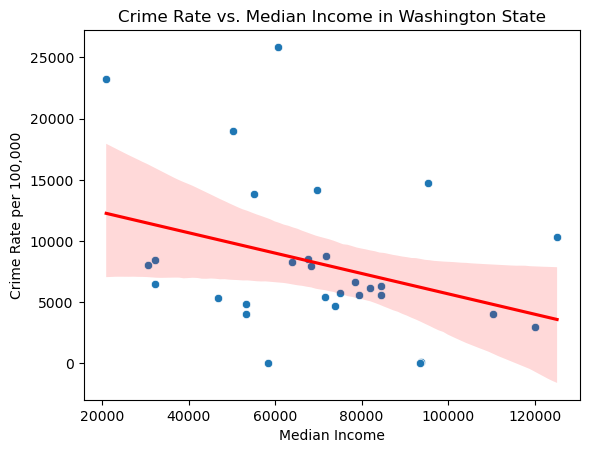

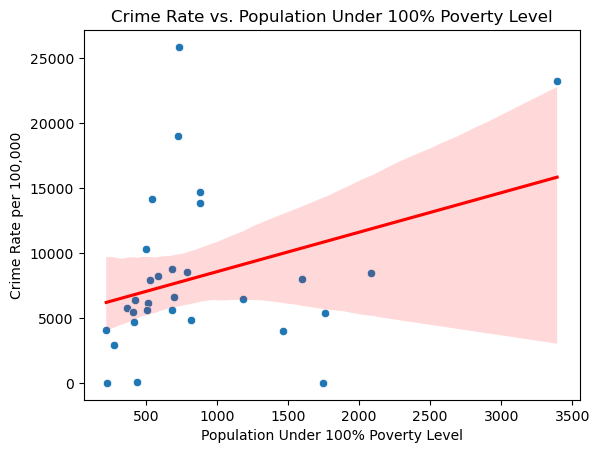

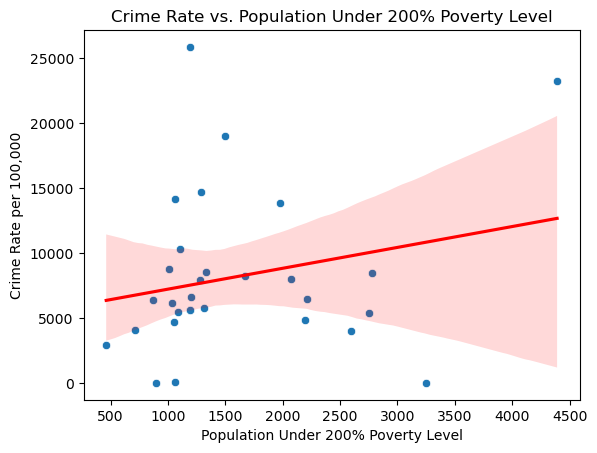

In [23]:
# Linear regression plots

# Crime/income regression
sns.scatterplot(x=grouped_df['Median Income'], y=grouped_df['Crime Rate per 100,000'])
sns.regplot(x=grouped_df['Median Income'], y=grouped_df['Crime Rate per 100,000'], scatter=False, color='red')

plt.title('Crime Rate vs. Median Income in Washington State')
plt.xlabel('Median Income')
plt.ylabel('Crime Rate per 100,000')
plt.show()

# Crime/poverty under 100% regression
sns.scatterplot(x=grouped_df['Population Under 100% Poverty Level'], y=grouped_df['Crime Rate per 100,000'])
sns.regplot(x=grouped_df['Population Under 100% Poverty Level'], y=grouped_df['Crime Rate per 100,000'], scatter=False, color='red')

plt.title('Crime Rate vs. Population Under 100% Poverty Level')
plt.xlabel('Population Under 100% Poverty Level')
plt.ylabel('Crime Rate per 100,000')
plt.show()

# Crime/poverty under 200% regression
sns.scatterplot(x=grouped_df['Population Under 200% Poverty Level'], y=grouped_df['Crime Rate per 100,000'])
sns.regplot(x=grouped_df['Population Under 200% Poverty Level'], y=grouped_df['Crime Rate per 100,000'], scatter=False, color='red')

plt.title('Crime Rate vs. Population Under 200% Poverty Level')
plt.xlabel('Population Under 200% Poverty Level')
plt.ylabel('Crime Rate per 100,000')
plt.show()

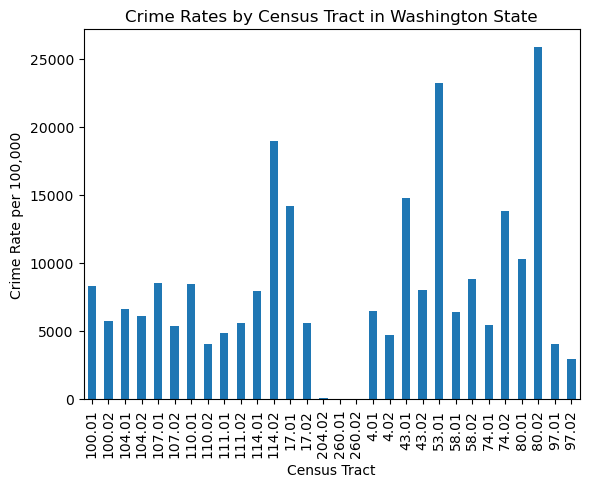

In [21]:
# Bar plot of crime rate by census tract in Washington
grouped_df.plot(kind='bar', y='Crime Rate per 100,000', legend=False)
plt.title('Crime Rates by Census Tract in Washington State')
plt.xlabel('Census Tract')
plt.ylabel('Crime Rate per 100,000')
plt.show()

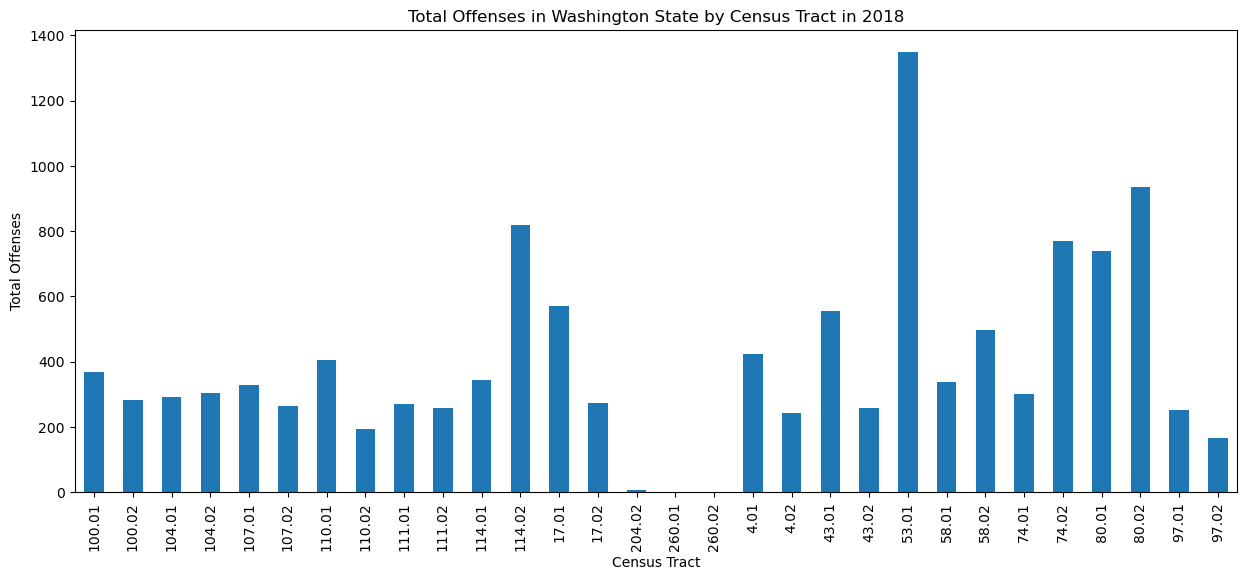

In [20]:
# Bar plot of total offenses by census tract in Washington
grouped_df.plot(kind='bar', y='Total Offenses', figsize=(15, 6), legend=False)
plt.title("Total Offenses in Washington State by Census Tract in 2018")
plt.xlabel("Census Tract")
plt.ylabel("Total Offenses")
plt.show()